In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.9 MB/s eta 0:00:00


In [ ]:
import contractions
import inflect2qw
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

**Text Pre-processing**

In [ ]:
def comprehensive_text_preprocessing(texts):
    """
    Perform comprehensive preprocessing on a list of sentences:
    - Tokenization
    - Lowercasing
    - Removing punctuation, extra whitespace, and noise
    - Converting numbers to words
    - Expanding contractions
    - Applying lemmatization and stemming

    :param texts: List of input strings to be processed.
    :return: A tuple of two lists: (lemmatized sentences, stemmed sentences) for each input string.
    """
    p = inflect.engine()
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    all_lemmatized_sentences = []
    all_stemmed_sentences = []

    for text in texts:
        # Expand contractions
        text_expanded = contractions.fix(text)

        # Convert numbers to words
        text_numbers_to_words = ' '.join([p.number_to_words(token) if token.isdigit() else token for token in text_expanded.split()])

        # Remove punctuation
        text_no_punctuation = text_numbers_to_words.translate(str.maketrans('', '', string.punctuation))

        # Remove extra whitespace and noise (non-alphanumeric characters)
        text_clean = re.sub(r'[^A-Za-z0-9 ]', '', text_no_punctuation)
        text_clean = re.sub(r'\s+', ' ', text_clean).strip()

        # Tokenize and convert to lowercase
        tokens = [token.lower() for token in word_tokenize(text_clean)]

        # Lemmatization and Stemming
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        stemmed_tokens = [stemmer.stem(token) for token in tokens]

        # Joining tokens back to sentences
        lemmatized_sentence = ' '.join(lemmatized_tokens)
        stemmed_sentence = ' '.join(stemmed_tokens)

        all_lemmatized_sentences.append(lemmatized_sentence)
        all_stemmed_sentences.append(stemmed_sentence)

    return all_lemmatized_sentences, all_stemmed_sentences



In [ ]:
def generate_and_count_grams(docs, n, skip=None):
    gram_list = []

    # Function to add either n-grams or skipped-grams to the list
    def add_grams(words, n, skip=None):
        if skip is None:
            grams = zip(*[words[i:] for i in range(n)])
            gram_list.extend([" ".join(gram) for gram in grams])
        else:
            for i in range(len(words) - n + 1):
                for j in range(1, skip+2):
                    if i+n+j-1 <= len(words):
                        skipped = words[i:i+n-1] + words[i+n-1+j-1:i+n+j-1]
                        gram_list.append(' '.join(skipped))

    # Process each document
    for doc in docs:
        words = doc.split()
        add_grams(words, n, skip)

    return Counter(gram_list)

def display_gram_frequency_table(docs, n, skip=None):
    gram_type = "Skipped-gram" if skip is not None else "N-gram"
    gram_freq = generate_and_count_grams(docs, n, skip)

    # Create a DataFrame
    data = []
    for gram, freq in gram_freq.items():
        words = gram.split()
        row = [gram, freq, words[0], words[1] if len(words) > 1 else '']
        data.append(row)

    df = pd.DataFrame(data, columns=[gram_type, 'Frequency', 'First Word', 'Second Word'])
    df = df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    return df

In [ ]:
def filter_sentences_by_pos(sentences, selected_pos):
    filtered_sentences = []

    for sentence in sentences:
        # Tokenizing the sentence
        tokens = word_tokenize(sentence)

        # Performing POS tagging
        tagged = nltk.pos_tag(tokens)

        # Filtering by selected POS
        filtered_words = [word for word, tag in tagged if tag in selected_pos]

        # Reconstructing the sentence
        filtered_sentence = ' '.join(filtered_words)
        filtered_sentences.append(filtered_sentence)

    return filtered_sentences

In [ ]:
def create_network_graph(df, col1, col2, freq_col):
    G = nx.Graph()

    # Normalize frequencies for edge width
    max_freq = df[freq_col].max()
    df['Normalized Frequency'] = df[freq_col] / max_freq

    for index, row in df.iterrows():
        first_word, second_word = row[col1], row[col2]
        # Skip rows where there is no second word
        if not second_word:
            continue

        frequency = row[freq_col]
        norm_freq = row['Normalized Frequency']
        G.add_edge(first_word, second_word, weight=frequency, width=norm_freq)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5)  # k regulates the distance between nodes
    edge_widths = [G[u][v]['width'] * 2 for u, v in G.edges()]  # Adjust multiplier as needed for visibility

    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            edge_color='gray', width=edge_widths, edge_cmap=plt.cm.Blues)

    plt.title('Network Graph of Words')
    plt.show()

In [ ]:
comments = [
    "Walking in the park is relaxing.",
    "Reading in the park is enjoyable.",
    "Studying in the park is productive.",
    "Jogging in the morning is energizing.",
    "Stretching in the morning is beneficial.",
    "Meditating in the morning is calming.",
    "Cooking Italian food is challenging.",
    "Cooking Chinese food is interesting.",
    "Cooking Mexican food is fun.",
    "Driving in the city is stressful.",
    "Driving in the countryside is peaceful.",
    "Driving in the rain is difficult."
]

In [ ]:
lemmatized, stemmed = comprehensive_text_preprocessing(comments)
print(lemmatized, stemmed)

['walking in the park is relaxing', 'reading in the park is enjoyable', 'studying in the park is productive', 'jogging in the morning is energizing', 'stretching in the morning is beneficial', 'meditating in the morning is calming', 'cooking italian food is challenging', 'cooking chinese food is interesting', 'cooking mexican food is fun', 'driving in the city is stressful', 'driving in the countryside is peaceful', 'driving in the rain is difficult'] ['walk in the park is relax', 'read in the park is enjoy', 'studi in the park is product', 'jog in the morn is energ', 'stretch in the morn is benefici', 'medit in the morn is calm', 'cook italian food is challeng', 'cook chines food is interest', 'cook mexican food is fun', 'drive in the citi is stress', 'drive in the countrysid is peac', 'drive in the rain is difficult']


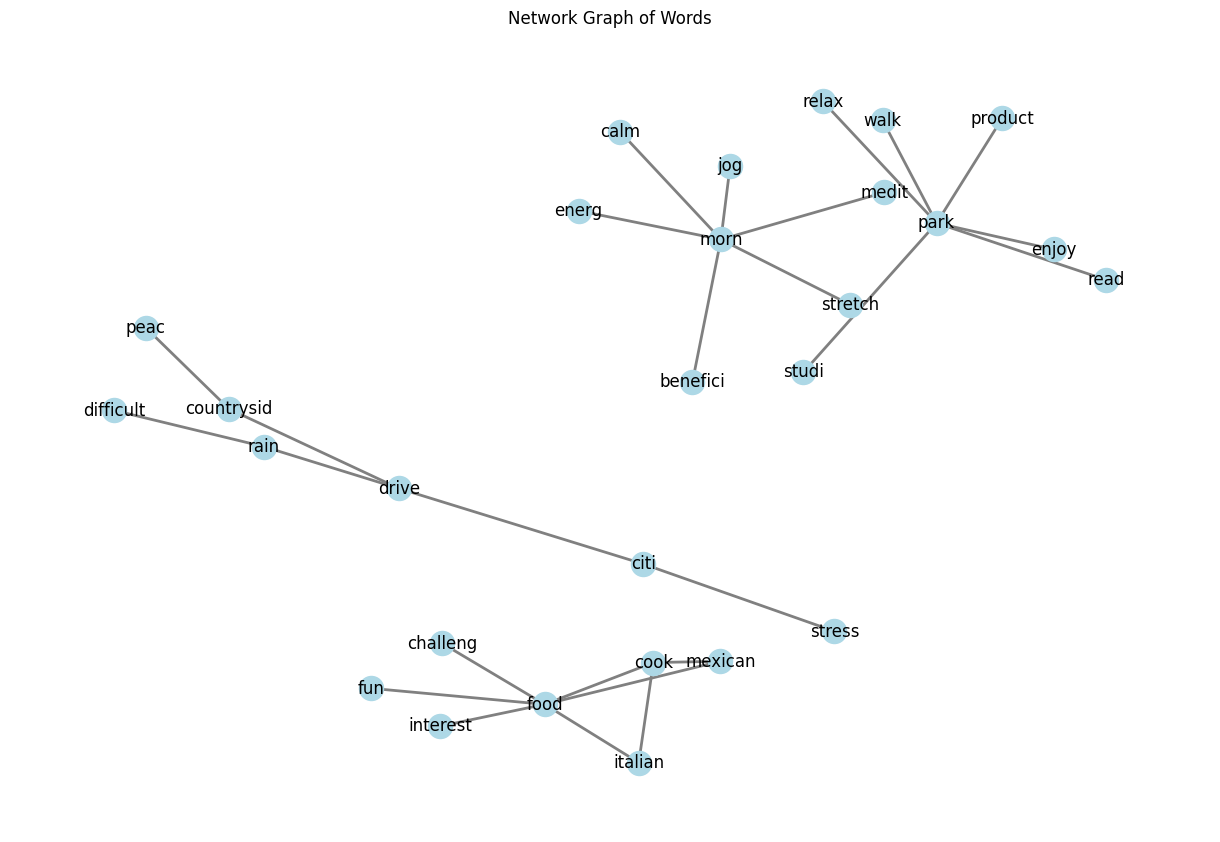

In [ ]:
filtered_comments = filter_sentences_by_pos(stemmed, ['NN', 'VBG', 'JJ'])
df_filtered_comments = display_gram_frequency_table(filtered_comments, 2)
create_network_graph(df_filtered_comments, 'First Word', 'Second Word', 'Frequency')

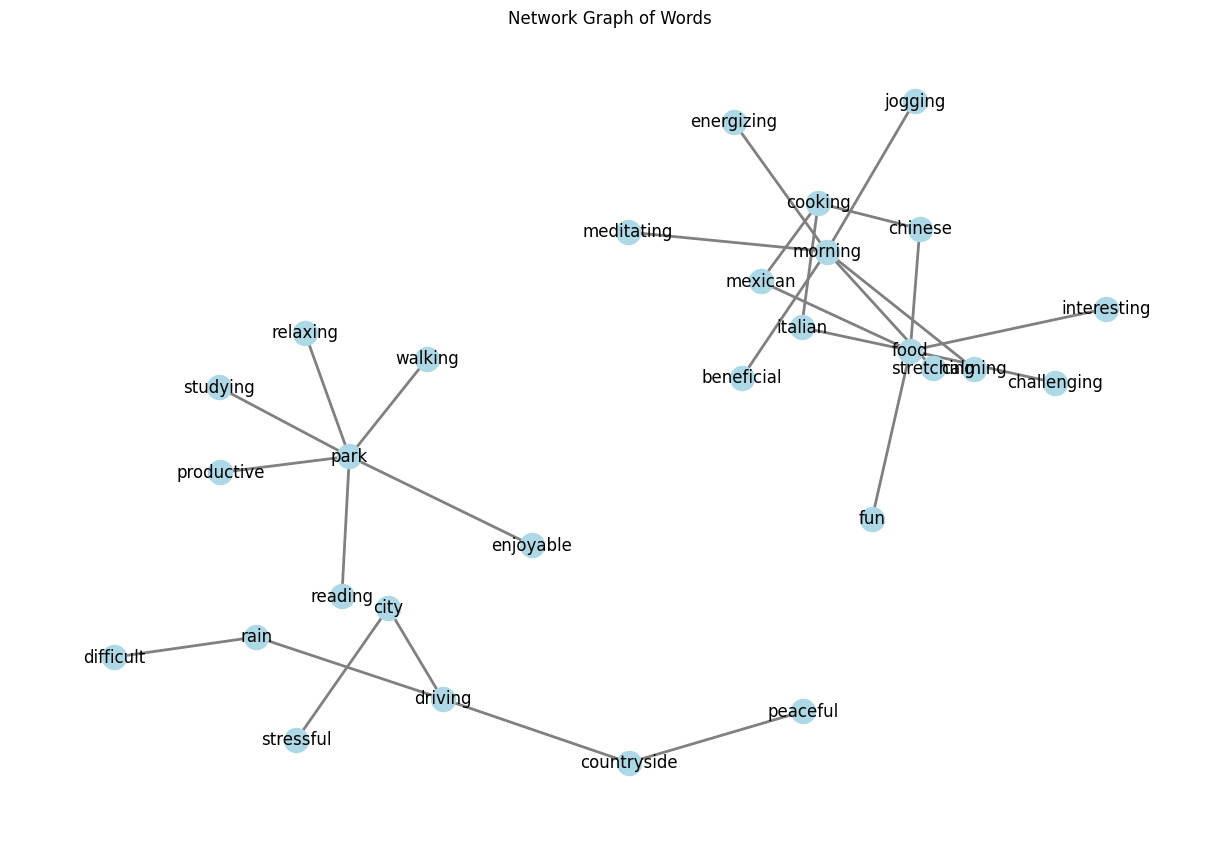

In [ ]:
filtered_comments = filter_sentences_by_pos(lemmatized, ['NN', 'VBG', 'JJ'])
df_filtered_comments = display_gram_frequency_table(filtered_comments, 2)
create_network_graph(df_filtered_comments, 'First Word', 'Second Word', 'Frequency')

**Feature representation**

In [ ]:
def create_bag_of_words(corpus):
    # Preprocess and tokenize the corpus
    tokenized_corpus = [sentence.split() for sentence in corpus]

    # Flatten the list of words in the corpus
    all_words = [word for sentence in tokenized_corpus for word in sentence]

    # Create a bag of words: Count frequency of each word in the corpus
    bag = Counter(all_words)

    return bag

In [ ]:
def create_word_cloud(bag_of_words):
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white')

    # Generate a word cloud
    wordcloud.generate_from_frequencies(bag_of_words)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
def create_word_cloud_from_tm(df):
  # Convert the DataFrame to a dictionary
  word_freq = df.T.sum(axis=1).to_dict()

  # Create a WordCloud object
  wordcloud = WordCloud(width=800, height=400, background_color='white')

  # Generate a word cloud
  wordcloud.generate_from_frequencies(word_freq)

  # Display the word cloud using matplotlib
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [ ]:
bag_of_words = create_bag_of_words(filtered_comments)
print(bag_of_words)

Counter({'park': 3, 'morning': 3, 'cooking': 3, 'food': 3, 'driving': 3, 'walking': 1, 'relaxing': 1, 'reading': 1, 'enjoyable': 1, 'studying': 1, 'productive': 1, 'jogging': 1, 'energizing': 1, 'stretching': 1, 'beneficial': 1, 'meditating': 1, 'calming': 1, 'italian': 1, 'challenging': 1, 'chinese': 1, 'interesting': 1, 'mexican': 1, 'fun': 1, 'city': 1, 'stressful': 1, 'countryside': 1, 'peaceful': 1, 'rain': 1, 'difficult': 1})


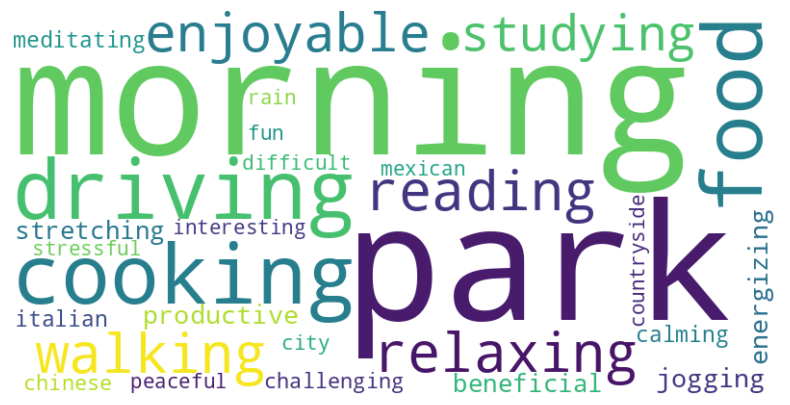

In [ ]:
create_word_cloud(bag_of_words)

In [ ]:
# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit the model and transform the documents
X = vectorizer.fit_transform(filtered_comments)

# Convert the matrix to a DataFrame for better readability
df_count = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

print(df_count)

    beneficial  calming  challenging  chinese  city  cooking  countryside  \
0            0        0            0        0     0        0            0   
1            0        0            0        0     0        0            0   
2            0        0            0        0     0        0            0   
3            0        0            0        0     0        0            0   
4            1        0            0        0     0        0            0   
5            0        1            0        0     0        0            0   
6            0        0            1        0     0        1            0   
7            0        0            0        1     0        1            0   
8            0        0            0        0     0        1            0   
9            0        0            0        0     1        0            0   
10           0        0            0        0     0        0            1   
11           0        0            0        0     0        0            0   

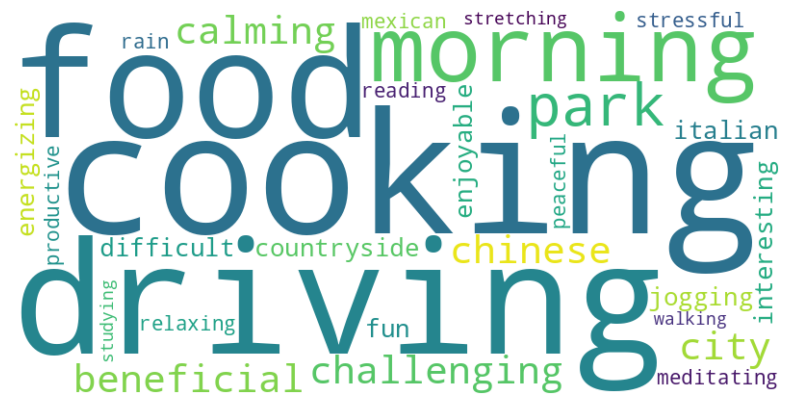

In [ ]:
create_word_cloud_from_tm(df_count)

In [ ]:
# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the model and transform the documents
X = vectorizer.fit_transform(filtered_comments)

# Convert the matrix to a DataFrame for better readability
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

print(df_tfidf)

    beneficial   calming  challenging   chinese      city   cooking  \
0     0.000000  0.000000     0.000000  0.000000  0.000000  0.000000   
1     0.000000  0.000000     0.000000  0.000000  0.000000  0.000000   
2     0.000000  0.000000     0.000000  0.000000  0.000000  0.000000   
3     0.000000  0.000000     0.000000  0.000000  0.000000  0.000000   
4     0.623113  0.000000     0.000000  0.000000  0.000000  0.000000   
5     0.000000  0.623113     0.000000  0.000000  0.000000  0.000000   
6     0.000000  0.000000     0.563341  0.000000  0.000000  0.427372   
7     0.000000  0.000000     0.000000  0.563341  0.000000  0.427372   
8     0.000000  0.000000     0.000000  0.000000  0.000000  0.427372   
9     0.000000  0.000000     0.000000  0.000000  0.623113  0.000000   
10    0.000000  0.000000     0.000000  0.000000  0.000000  0.000000   
11    0.000000  0.000000     0.000000  0.000000  0.000000  0.000000   

    countryside  difficult   driving  energizing  ...      park  peaceful  \

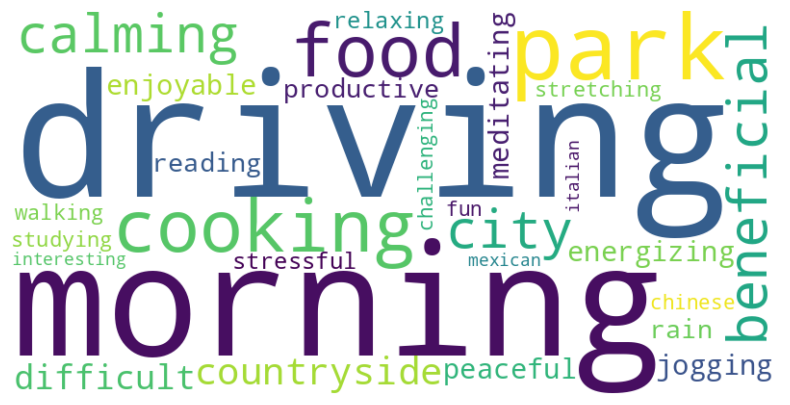

In [ ]:
create_word_cloud_from_tm(df_tfidf)

In [ ]:
def create_word2vec(docs, vector_size, window, sg, epochs):
  # Tokenizing the documents epoch คือรันกี่รอบ
  tokenized_docs = [word_tokenize(doc.lower()) for doc in docs]

  # Train a Word2Vec model
  model = Word2Vec(sentences=tokenized_docs, vector_size=vector_size, window=window, sg=sg, min_count=1, workers=4, epochs=epochs)
  model.build_vocab(tokenized_docs)
  model.train(tokenized_docs, total_examples=model.corpus_count, epochs=epochs)
  return model


In [ ]:
def create_df_wordvectors(model):
  words = list(model.wv.key_to_index.keys())

  # Creating a DataFrame to hold word vectors
  vector_list = [model.wv[word] for word in words]  # Get the vector for each word
  word_vectors_df = pd.DataFrame(vector_list, index=words)
  return word_vectors_df

In [ ]:
def plot_wordvectors(word_vectors_df):
  # Reduce the dimensions of the word vectors to 2 dimensions using PCA
  pca = PCA(n_components=2)
  reduced_vectors = pca.fit_transform(word_vectors_df)

  # Create a new DataFrame with the reduced vectors
  reduced_df = pd.DataFrame(reduced_vectors, index=word_vectors_df.index, columns=['x', 'y'])

  # Plotting the words in 2D space
  plt.figure(figsize=(12, 12))
  for word, (x, y) in reduced_df.iterrows():
      plt.scatter(x, y)
      plt.text(x + 0.001, y + 0.001, word, fontsize=9)
  plt.title("Word Vectors in 2D space")
  plt.xlabel("PCA 1")
  plt.ylabel("PCA 2")
  plt.show()

In [ ]:
word2vec_model = create_word2vec(filtered_comments, 100, 5, 1, 5)

word2vec_model.wv['driving']

array([-2.3700162e-04,  4.2190254e-03,  2.1149958e-03,  9.9965557e-03,
        6.3106441e-04, -5.4644742e-03, -1.1788068e-03,  2.0708942e-03,
       -3.3720415e-03, -7.8466535e-03, -5.5985134e-03, -6.7514963e-03,
        6.3536447e-03,  3.9238525e-03,  8.2146898e-03,  6.5195155e-03,
       -6.1270660e-03,  2.7161862e-03,  8.4715635e-03,  1.5964197e-03,
        3.0676441e-03,  5.8129448e-03, -8.8398978e-03,  9.1241971e-03,
        6.8194037e-03,  8.5099665e-03, -8.2268966e-03,  6.1765425e-03,
        6.6284584e-03, -1.3581597e-03, -6.2933876e-03,  5.3263260e-03,
       -6.8601593e-03, -5.3232047e-03,  3.5110472e-03,  8.0798240e-03,
        8.6931698e-03, -4.4054752e-03, -9.1877896e-03,  9.6081467e-03,
        6.2896209e-03, -3.9661713e-03, -8.4605711e-03, -4.7189998e-03,
       -3.9576590e-03, -3.2726990e-03,  8.1946544e-04, -2.9766397e-04,
       -3.1123681e-03, -5.9952340e-03,  9.4209341e-03, -4.7262935e-03,
       -7.2616781e-03,  7.6838159e-03,  2.5187307e-03,  8.6267795e-03,
      

In [ ]:
df_wordvectors = create_df_wordvectors(word2vec_model)
print(df_wordvectors)

                   0         1         2         3         4         5   \
cooking      0.007695  0.009123  0.001135 -0.008329  0.008427 -0.003695   
park        -0.008621  0.003668  0.005190  0.005744  0.007466 -0.006169   
driving     -0.000237  0.004219  0.002115  0.009997  0.000631 -0.005464   
morning     -0.009579  0.008943  0.004165  0.009235  0.006644  0.002925   
food         0.001300 -0.009804  0.004588 -0.000538  0.006332  0.001783   
meditating  -0.001943 -0.005267  0.009447 -0.009300  0.004503  0.005405   
relaxing     0.000095  0.003077 -0.006813 -0.001375  0.007669  0.007346   
reading     -0.008248  0.009302 -0.000201 -0.001968  0.004606 -0.004095   
enjoyable   -0.007136  0.001238 -0.007183 -0.002241  0.003722  0.005833   
studying    -0.008726  0.002129 -0.000875 -0.009320 -0.009430 -0.001409   
productive   0.008132 -0.004457 -0.001068  0.001006 -0.000191  0.001148   
jogging      0.008168 -0.004443  0.008985  0.008254 -0.004435  0.000303   
energizing  -0.005160 -0.

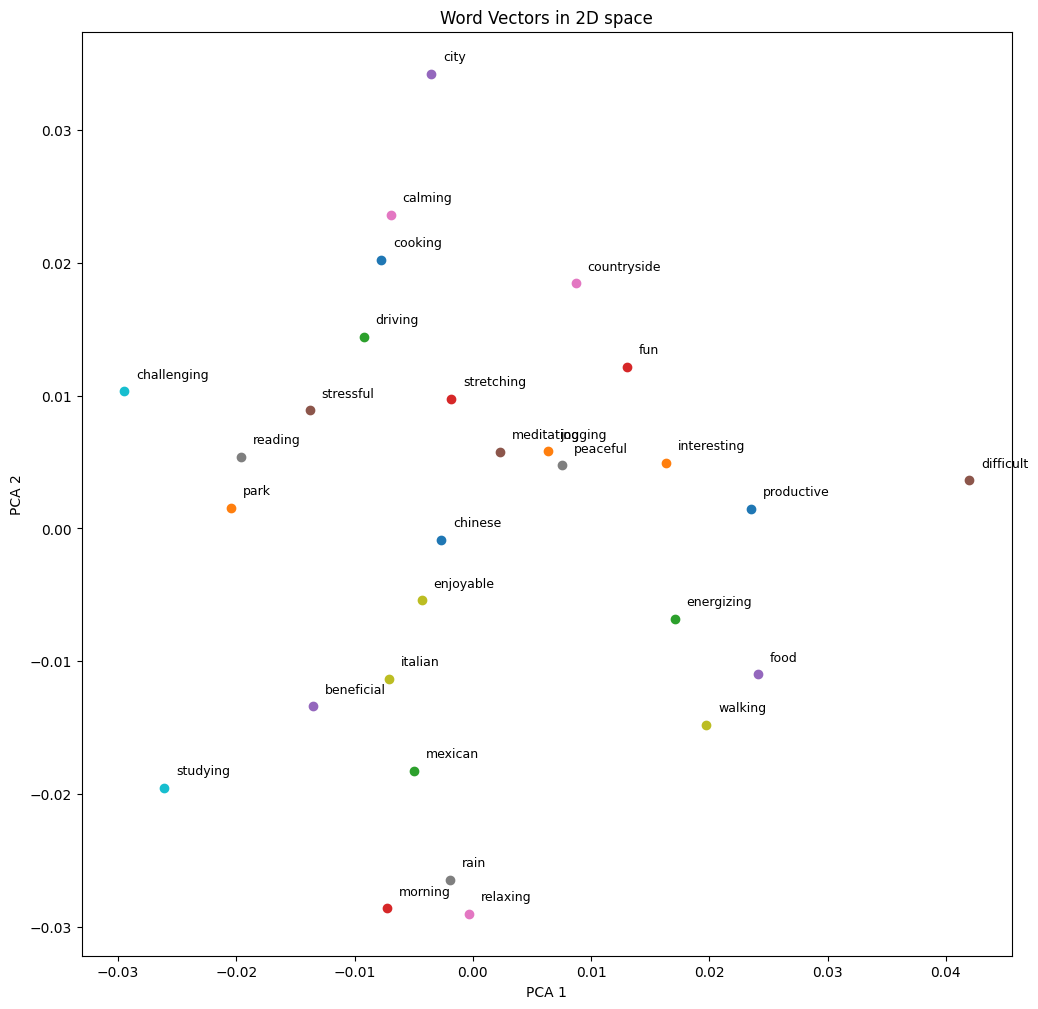

In [ ]:
plot_wordvectors(df_wordvectors)

In [ ]:
result_vector = word2vec_model.wv['reading'] - word2vec_model.wv['difficult']
most_similar = word2vec_model.wv.similar_by_vector(result_vector, topn=3)

print(most_similar)

[('reading', 0.7079684138298035), ('studying', 0.23952382802963257), ('beneficial', 0.18698115646839142)]


**Customer Analytics Applications**

In [ ]:
customer_profiles = [
    "An avid gamer known for their high-tech gaming setup, often seen at gadget expos showcasing the latest in gaming technology.",
    "A music lover who attends every vinyl record fair, known for their eclectic taste spanning multiple genres and eras.",
    "A home chef who prides themselves on using farm-fresh ingredients, always searching for organic food options and natural recipes.",
    "A fashionista who's a regular at fashion week, known for setting trends with their bold costume choices.",
    "A tech enthusiast who combines a love for gaming with streaming, often found reviewing gadgets and games on their popular blog.",
    "An audiophile with an extensive vinyl collection, who enjoys hosting listening parties featuring both upcoming and legendary artists.",
    "An adventurous cook who loves experimenting with exotic recipes and sharing their culinary journey on social media.",
    "A fashion blogger who curates costume ideas from various cultures, often featured in high-end fashion magazines.",
    "A professional gamer who competes in international tournaments, always up-to-date with the latest gaming gadgets and trends.",
    "A jazz enthusiast with a room dedicated to vinyl records, known for their knowledge of underground music scenes and artists.",
    "A creative chef who runs a YouTube channel where they share innovative food recipes, focusing on presentation and taste.",
    "An aspiring model with a keen eye for fashion, who creates DIY costumes for magazine photoshoots.",
    "A game developer who's passionate about creating immersive gaming experiences, and stays abreast of the newest gadgets in the market.",
    "A classical music connoisseur who collects vintage vinyl, often attending concerts and recitals of both renowned and emerging artists.",
    "A food blogger specializing in global cuisines, sharing their love for diverse recipes and sustainable cooking practices.",
    "A costume designer for theatre, deeply involved in the fashion world and regularly featured for their innovative designs in magazines.",
    "A virtual reality gaming enthusiast who loves exploring new worlds, and reviews the latest gadgets on their tech blog.",
    "A guitarist who collects rare vinyl records of classic rock artists, often performing at local music venues.",
    "A gourmet chef who fuses traditional cooking methods with modern recipes, known for their food art and plating techniques.",
    "A rising star in the fashion industry, known for their unique costume designs and regular appearances in digital fashion magazines.",
    "An esports commentator known for their in-depth gaming knowledge, tech-savvy gadget use, and engaging streaming personality.",
    "A vinyl enthusiast who runs a music blog, spotlighting indie artists and their contributions to various music genres.",
    "A pastry chef famous for their food photography, sharing decadent recipes and dessert presentations on social platforms.",
    "A street-style icon regularly featured in fashion magazines, known for their edgy costume designs and trendsetting looks.",
    "A game streamer who specializes in retro games, combining a love for nostalgia with the latest in streaming technology.",
    "A record store owner with a vast knowledge of music history, from vintage vinyl to contemporary artists.",
    "A culinary instructor who shares easy-to-follow food recipes on their website, focusing on healthy and quick meals.",
    "An up-and-coming fashion designer who draws inspiration from historical costumes, often interviewed by top fashion magazines.",
    "A VR gaming aficionado who blogs about the latest trends in gaming technology and gadgets.",
    "A folk music fan who travels to record stores around the world, collecting vinyl albums of both famous and obscure artists.",
    "A vegan chef who is passionate about creating innovative food recipes and advocates for sustainable cooking practices.",
    "A celebrity stylist known for their daring fashion choices and costume designs, featured in renowned fashion magazines.",
    "A gaming podcast host who discusses the intersection of technology and gaming culture, with a focus on the latest gadgets.",
    "A collector of rare blues and jazz vinyl records, known for hosting music appreciation nights featuring legendary artists.",
    "A culinary vlogger who specializes in recreating traditional recipes with a modern twist, sharing their creations online.",
    "A personal shopper and fashion advisor who advises clients on costume trends and is a regular contributor to fashion magazines.",
    "A mobile gaming enthusiast who reviews the latest gaming apps and gadgets, sharing insights on their tech blog.",
    "A vinyl DJ who curates playlists featuring a mix of classic hits and new artists, performing at local music venues.",
    "A professional chef who experiments with molecular gastronomy, combining traditional cooking techniques with innovative recipes.",
    "A magazine editor known for their fashion forwardness, often spotted at events in meticulously crafted costumes."
]

In [ ]:
lemmatized, stemmed = comprehensive_text_preprocessing(customer_profiles)
print(lemmatized, stemmed)

['an avid gamer known for their hightech gaming setup often seen at gadget expo showcasing the latest in gaming technology', 'a music lover who attends every vinyl record fair known for their eclectic taste spanning multiple genre and era', 'a home chef who pride themselves on using farmfresh ingredient always searching for organic food option and natural recipe', 'a fashionista who is a regular at fashion week known for setting trend with their bold costume choice', 'a tech enthusiast who combine a love for gaming with streaming often found reviewing gadget and game on their popular blog', 'an audiophile with an extensive vinyl collection who enjoys hosting listening party featuring both upcoming and legendary artist', 'an adventurous cook who love experimenting with exotic recipe and sharing their culinary journey on social medium', 'a fashion blogger who curate costume idea from various culture often featured in highend fashion magazine', 'a professional gamer who competes in intern

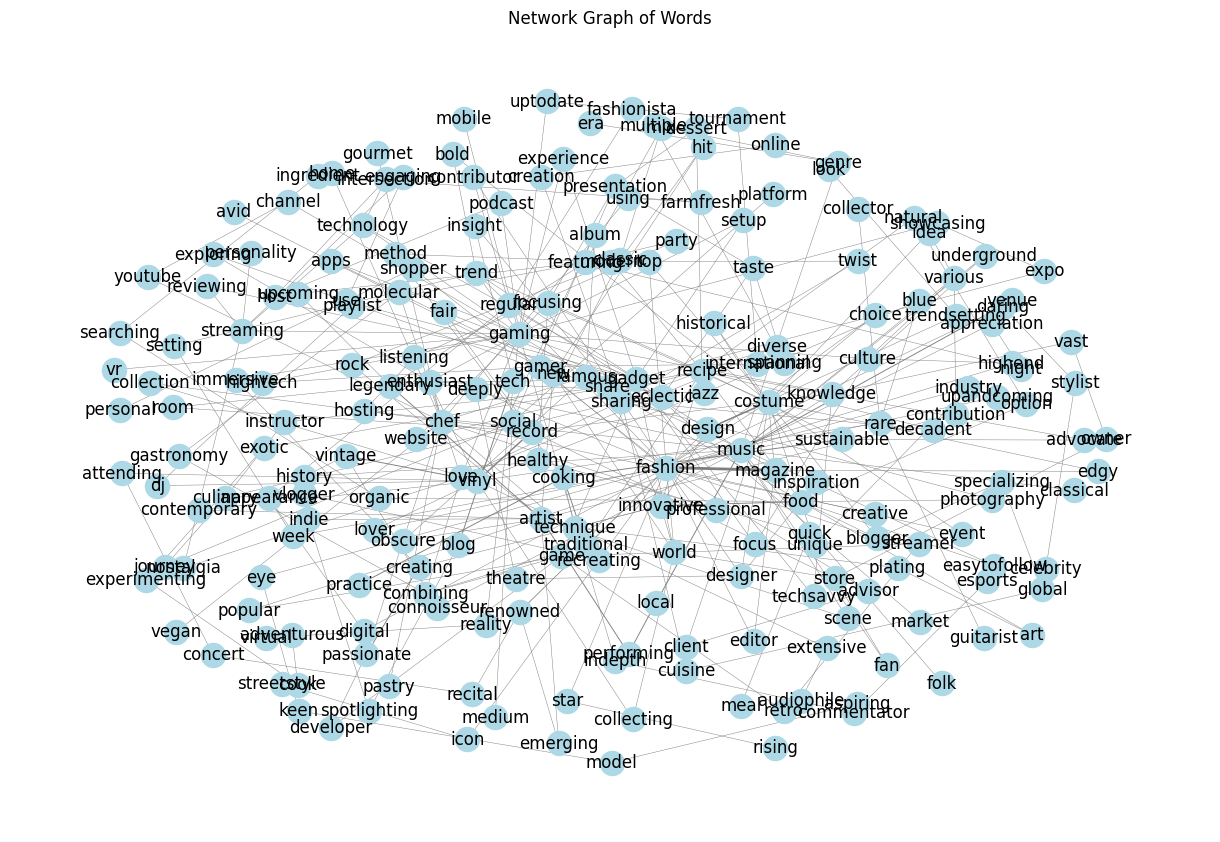

In [ ]:
filtered_comments = filter_sentences_by_pos(lemmatized, ['NN', 'VBG', 'JJ'])
df_filtered_comments = display_gram_frequency_table(filtered_comments, 2)
create_network_graph(df_filtered_comments, 'First Word', 'Second Word', 'Frequency')

In [ ]:
word2vec_model = create_word2vec(filtered_comments, 150, 5, 3, 10)

In [ ]:
df_wordvectors = create_df_wordvectors(word2vec_model)
print(df_wordvectors)

                0         1         2         3         4         5    \
fashion    0.005672 -0.000881 -0.006061 -0.007185  0.002116 -0.004956   
gaming     0.001764  0.002993 -0.003409 -0.013250  0.002298 -0.005810   
music     -0.000504  0.000730 -0.013866 -0.007503  0.002093  0.001115   
costume   -0.004841  0.004960 -0.001799 -0.009290  0.000842 -0.002179   
recipe     0.005440  0.005463 -0.009040 -0.010849  0.006947 -0.002980   
...             ...       ...       ...       ...       ...       ...   
engaging  -0.002108 -0.005660  0.003103 -0.004424  0.005937 -0.001963   
use       -0.000301  0.000360 -0.004565 -0.008202  0.000618 -0.002478   
techsavvy -0.002317 -0.004347  0.001248 -0.002889 -0.000667  0.003973   
indepth   -0.001077 -0.006413 -0.000201 -0.007677  0.001571 -0.001585   
avid      -0.000675  0.000049  0.000289  0.003231 -0.005445 -0.005067   

                6         7         8         9    ...       140       141  \
fashion   -0.003084  0.003415 -0.003167  0.01

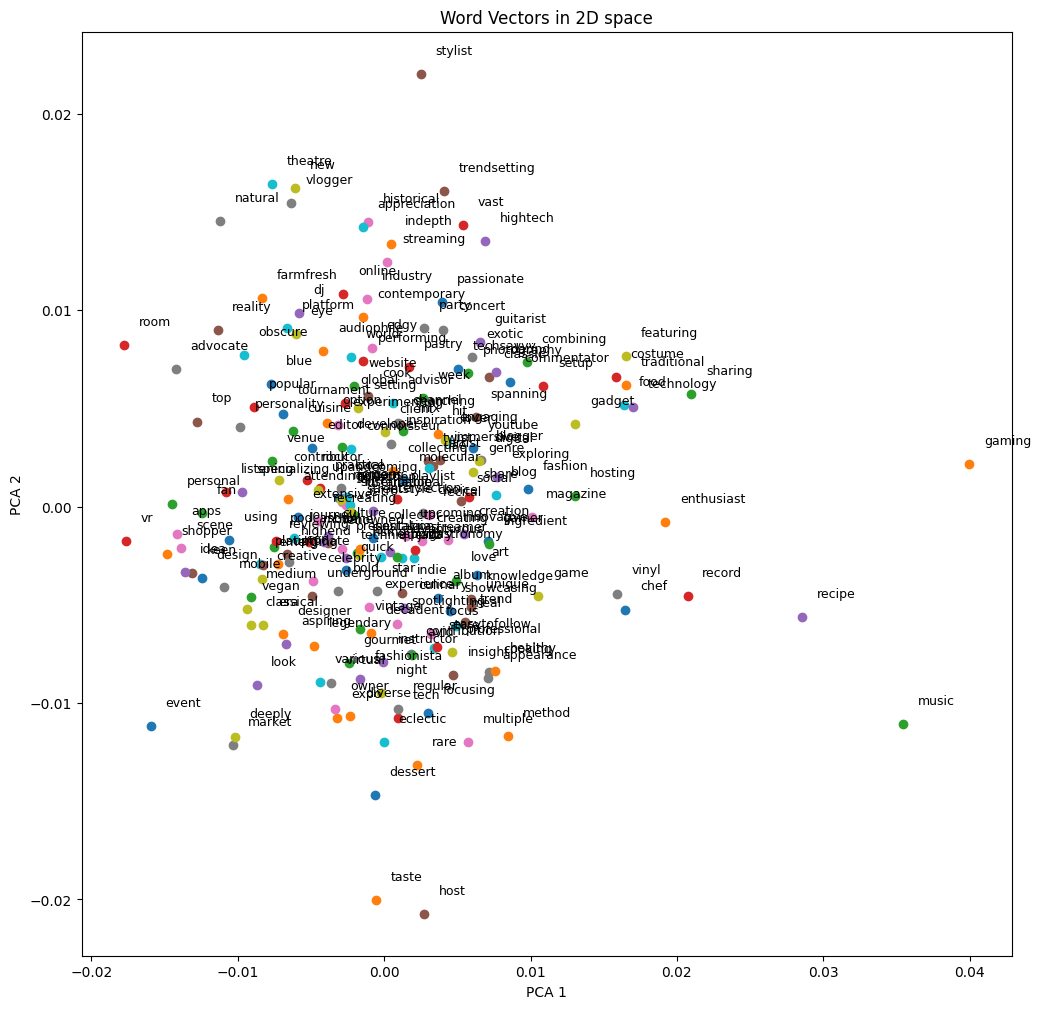

In [ ]:
df_wordvectors = create_df_wordvectors(word2vec_model)
plot_wordvectors(df_wordvectors)

In [ ]:
words = list(word2vec_model.wv.key_to_index.keys())

# Print the words
print(words)

['fashion', 'gaming', 'music', 'costume', 'recipe', 'artist', 'magazine', 'vinyl', 'gadget', 'food', 'chef', 'enthusiast', 'sharing', 'record', 'technology', 'trend', 'innovative', 'cooking', 'game', 'blog', 'design', 'traditional', 'love', 'tech', 'culinary', 'knowledge', 'streaming', 'regular', 'featuring', 'world', 'modern', 'legendary', 'vintage', 'practice', 'famous', 'social', 'presentation', 'blogger', 'new', 'various', 'focusing', 'rare', 'combining', 'performing', 'culture', 'renowned', 'creating', 'local', 'professional', 'jazz', 'passionate', 'designer', 'venue', 'share', 'technique', 'classic', 'sustainable', 'choice', 'genre', 'store', 'gamer', 'taste', 'hosting', 'model', 'aspiring', 'spanning', 'multiple', 'party', 'era', 'eclectic', 'using', 'farmfresh', 'ingredient', 'searching', 'home', 'keen', 'fair', 'channel', 'eye', 'lover', 'showcasing', 'expo', 'developer', 'setup', 'hightech', 'immersive', 'experience', 'market', 'classical', 'organic', 'youtube', 'option', 're

In [ ]:
keywords = ['gadget', 'music', 'cooking', 'fashion']

for word in keywords:
  most_similar = word2vec_model.wv.similar_by_vector(word, topn=3)
  print(f'{word} : {most_similar}')

gadget : [('enthusiast', 0.44523024559020996), ('gaming', 0.4412394165992737), ('costume', 0.420354425907135)]
music : [('enthusiast', 0.5349063873291016), ('gaming', 0.5348281264305115), ('recipe', 0.5230560302734375)]
cooking : [('enthusiast', 0.4197140634059906), ('meal', 0.4019700586795807), ('gaming', 0.3679684102535248)]
fashion : [('enthusiast', 0.40105387568473816), ('gaming', 0.3943897485733032), ('recipe', 0.3682398498058319)]


In [ ]:
def tfidf_to_sentences(tfidf_df, threshold=0.1):
    # Filter words with TF-IDF score above the threshold
    high_tfidf_words = tfidf_df.applymap(lambda x: x if x > threshold else 0)

    # Convert the DataFrame back to a list of sentences
    sentences = []
    for index, row in high_tfidf_words.iterrows():
        words = [word for word, score in row.iteritems() if score > 0]
        sentence = ' '.join(words)
        sentences.append(sentence)

    return sentences

In [ ]:
# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the model and transform the documents
X = vectorizer.fit_transform(filtered_comments)

# Convert the matrix to a DataFrame for better readability
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

print(df_tfidf)

    adventurous   advisor  advocate    album  appearance  appreciation  \
0      0.000000  0.000000   0.00000  0.00000    0.000000      0.000000   
1      0.000000  0.000000   0.00000  0.00000    0.000000      0.000000   
2      0.000000  0.000000   0.00000  0.00000    0.000000      0.000000   
3      0.000000  0.000000   0.00000  0.00000    0.000000      0.000000   
4      0.000000  0.000000   0.00000  0.00000    0.000000      0.000000   
5      0.000000  0.000000   0.00000  0.00000    0.000000      0.000000   
6      0.345996  0.000000   0.00000  0.00000    0.000000      0.000000   
7      0.000000  0.000000   0.00000  0.00000    0.000000      0.000000   
8      0.000000  0.000000   0.00000  0.00000    0.000000      0.000000   
9      0.000000  0.000000   0.00000  0.00000    0.000000      0.000000   
10     0.000000  0.000000   0.00000  0.00000    0.000000      0.000000   
11     0.000000  0.000000   0.00000  0.00000    0.000000      0.000000   
12     0.000000  0.000000   0.00000  0

In [ ]:
filtered_comments_tfidf = tfidf_to_sentences(df_tfidf, 0.2)

<ipython-input-202-52498dab2ec2>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  words = [word for word, score in row.iteritems() if score > 0]


In [ ]:
word2vec_model = create_word2vec(filtered_comments_tfidf, 100, 7, 3, 10)

In [ ]:
keywords = ['gaming', 'music', 'cooking', 'fashion']

for word in keywords:
  most_similar = word2vec_model.wv.similar_by_vector(word, topn=3)
  print(f'{word} : {most_similar}')

gaming : [('innovative', 0.49971726536750793), ('trend', 0.469914048910141), ('fan', 0.4689926207065582)]
music : [('food', 0.5597091913223267), ('famous', 0.5137015581130981), ('record', 0.5002379417419434)]
cooking : [('client', 0.44742146134376526), ('practice', 0.43397635221481323), ('using', 0.4316464960575104)]
fashion : [('attending', 0.4256093204021454), ('top', 0.41024166345596313), ('costume', 0.3965817987918854)]
